In [2]:
import pandas as pd
import numpy as np
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
import torch


In [7]:
# Load the dataset
file_path = '/user/HS400/dd00830/Downloads/Dissertation/Dataset.csv'
dataset = pd.read_csv(file_path)

# Drop rows with missing values in 'selftext' and 'Label' columns
dataset_clean = dataset.dropna(subset=['selftext', 'Label'])

# Map labels in the dataset to integers using the lowercased label map
dataset_clean['Label'] = dataset_clean['Label'].str.lower()

# Clean the labels by stripping leading/trailing spaces
dataset_clean['Label'] = dataset_clean['Label'].str.strip()

# Map cleaned labels to integers
label_map = {label: idx for idx, label in enumerate(dataset_clean['Label'].unique())}

# Print the label map to verify
print(label_map)

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.replace('\n', ' ')  # Replace newlines with spaces
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])  # Remove special characters
    return text

# Apply text preprocessing to 'selftext'
dataset_clean['selftext'] = dataset_clean['selftext'].apply(preprocess_text)



{'drug and alcohol': 0, 'early life': 1, 'personality': 2, 'trauma and stress': 3}


/tmp/ipykernel_237263/2582620873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['Label'] = dataset_clean['Label'].str.lower()
/tmp/ipykernel_237263/2582620873.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['Label'] = dataset_clean['Label'].str.strip()
/tmp/ipykernel_237263/2582620873.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [9]:
# Initialize ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize the 'selftext' data
tokenized_inputs = dataset_clean['selftext'].apply(
    lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128)
)


In [10]:
# Convert to a Hugging Face Dataset
dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in tokenized_inputs],
    'attention_mask': [x['attention_mask'] for x in tokenized_inputs],
    'labels': dataset_clean['Label'].map(label_map).tolist()
}))

# Split the dataset into training and testing sets
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()


In [11]:
# Initialize the data collator with padding
data_collator = DataCollatorWithPadding(tokenizer)


In [12]:
# Define accuracy metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [13]:
# Set up training arguments with logging and evaluation strategy
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save the model at the end of each epoch
    logging_strategy="epoch",     # Log training metrics at the end of each epoch
    learning_rate=2e-5,           # Experiment with different learning rates
    per_device_train_batch_size=8,  # Experiment with batch size
    per_device_eval_batch_size=8,
    num_train_epochs=10,           # Experiment with different numbers of epochs
    weight_decay=0.01,
    load_best_model_at_end=True,  # Save the best model during training
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
)


In [14]:
# Initialize the ALBERT model
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_map))


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Include additional metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)


In [16]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.407900,1.386652,0.212500,0.045156,0.212500,0.074485
2,1.263400,0.961691,0.593750,0.580933,0.593750,0.568243
3,0.766800,1.193410,0.525000,0.655009,0.525000,0.483127
4,0.602000,0.851855,0.718750,0.738796,0.718750,0.711644
5,0.385200,0.917912,0.681250,0.688179,0.681250,0.669889
6,0.232100,1.157378,0.681250,0.718516,0.681250,0.686007
7,0.126700,1.224583,0.668750,0.682372,0.668750,0.672584
8,0.075200,1.428705,0.700000,0.705486,0.700000,0.699170
9,0.056100,1.428891,0.700000,0.716579,0.700000,0.704902
10,0.042400,1.441378,0.693750,0.708042,0.693750,0.697701


/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=800, training_loss=0.49578908294439317, metrics={'train_runtime': 231.2748, 'train_samples_per_second': 27.673, 'train_steps_per_second': 3.459, 'total_flos': 38244522393600.0, 'train_loss': 0.49578908294439317, 'epoch': 10.0})

In [17]:
# Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)  

{'eval_loss': 0.8518549203872681, 'eval_accuracy': 0.71875, 'eval_precision': 0.7387959898051362, 'eval_recall': 0.71875, 'eval_f1': 0.7116440973360133, 'eval_runtime': 1.708, 'eval_samples_per_second': 93.678, 'eval_steps_per_second': 11.71, 'epoch': 10.0}


                   precision    recall  f1-score   support

 drug and alcohol       0.71      0.94      0.81        31
       early life       0.82      0.84      0.83        49
      personality       0.81      0.48      0.60        46
trauma and stress       0.55      0.68      0.61        34

         accuracy                           0.72       160
        macro avg       0.72      0.73      0.71       160
     weighted avg       0.74      0.72      0.71       160



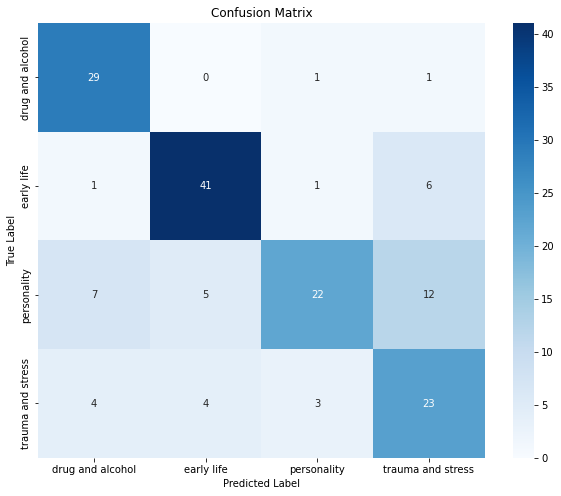

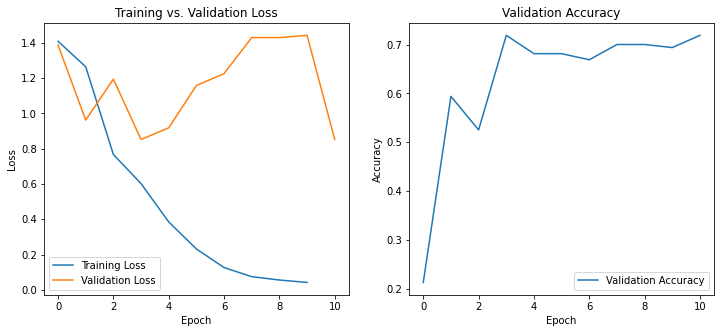

In [18]:
# Get predictions for classification report
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=label_map.keys())

# Print the classification report
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Extract loss and accuracy from log history for plotting
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'accuracy' in log:
        train_accuracy.append(log['accuracy'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()




## HYPER PARAMETER TUNING:-

In [21]:
import optuna
import tensorflow as tf
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming `dataset_clean` has 'selftext' and 'Label'
texts = dataset_clean['selftext'].tolist()
labels = dataset_clean['Label'].tolist()

# Convert labels to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_epochs', 2, 4)
    max_length = trial.suggest_int('max_length', 128, 256)

    # Load the tokenizer and model
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
    model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_map))

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).shuffle(len(train_texts)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(batch_size)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Train the model
    model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

    # Evaluate the model
    eval_loss, eval_accuracy = model.evaluate(val_dataset)

    # We want to minimize the loss
    return eval_loss  # or return -eval_accuracy if you want to maximize accuracy

# Run the hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters found: ", study.best_params)


[I 2024-09-04 06:08:26,604] A new study created in memory with name: no-name-30e4fb62-8fdb-434f-a348-83062442f094
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
80/80 [==============================] - 203s 2s/step - loss: 1.4171 - sparse_categorical_accuracy: 0.2719 - val_loss: 1.3991 - val_sparse_categorical_accuracy: 0.2812
Epoch 2/4
80/80 [==============================] - 173s 2s/step - loss: 1.3913 - sparse_categorical_accuracy: 0.2781 - val_loss: 1.3847 - val_sparse_categorical_accuracy: 0.2688
Epoch 3/4
80/80 [==============================] - 173s 2s/step - loss: 1.3978 - sparse_categorical_accuracy: 0.2500 - val_loss: 1.4039 - val_sparse_categorical_accuracy: 0.2750
Epoch 4/4
20/20 [==============================] - 13s 669ms/step - loss: 1.3899 - sparse_categorical_accuracy: 0.2188


[I 2024-09-04 06:20:44,208] Trial 0 finished with value: 1.3898561000823975 and parameters: {'learning_rate': 4.21957939838539e-05, 'batch_size': 8, 'num_epochs': 4, 'max_length': 158}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
40/40 [==============================] - 228s 5s/step - loss: 1.3947 - sparse_categorical_accuracy: 0.3078 - val_loss: 1.3205 - val_sparse_categorical_accuracy: 0.3812
Epoch 2/4
40/40 [==============================] - 209s 5s/step - loss: 1.1154 - sparse_categorical_accuracy: 0.5203 - val_loss: 0.9851 - val_sparse_categorical_accuracy: 0.6562
Epoch 3/4
40/40 [==============================] - 209s 5s/step - loss: 0.7303 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.6187
Epoch 4/4
10/10 [==============================] - 17s 2s/step - loss: 0.8293 - sparse_categorical_accuracy: 0.6938


[I 2024-09-04 06:35:18,997] Trial 1 finished with value: 0.8292682766914368 and parameters: {'learning_rate': 2.284042292122501e-05, 'batch_size': 16, 'num_epochs': 4, 'max_length': 192}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
20/20 [==============================] - 245s 12s/step - loss: 1.4084 - sparse_categorical_accuracy: 0.2672 - val_loss: 1.3608 - val_sparse_categorical_accuracy: 0.3313
Epoch 2/4
20/20 [==============================] - 225s 11s/step - loss: 1.2811 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.4812
Epoch 3/4
20/20 [==============================] - 224s 11s/step - loss: 1.0009 - sparse_categorical_accuracy: 0.6562 - val_loss: 1.0146 - val_sparse_categorical_accuracy: 0.5938
Epoch 4/4
5/5 [==============================] - 19s 4s/step - loss: 0.8172 - sparse_categorical_accuracy: 0.7188


[I 2024-09-04 06:51:06,444] Trial 2 finished with value: 0.8172022700309753 and parameters: {'learning_rate': 1.9750669781299764e-05, 'batch_size': 32, 'num_epochs': 4, 'max_length': 199}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
20/20 [==============================] - 216s 10s/step - loss: 1.3951 - sparse_categorical_accuracy: 0.2766 - val_loss: 1.3876 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/4
20/20 [==============================] - 198s 10s/step - loss: 1.3375 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.2688 - val_sparse_categorical_accuracy: 0.5437
Epoch 3/4
20/20 [==============================] - 198s 10s/step - loss: 1.0904 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.9648 - val_sparse_categorical_accuracy: 0.6438
Epoch 4/4
5/5 [==============================] - 17s 3s/step - loss: 0.8256 - sparse_categorical_accuracy: 0.6750


[I 2024-09-04 07:04:54,411] Trial 3 finished with value: 0.8256260752677917 and parameters: {'learning_rate': 1.980691820038876e-05, 'batch_size': 32, 'num_epochs': 4, 'max_length': 179}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
20/20 [==============================] - 275s 13s/step - loss: 1.3720 - sparse_categorical_accuracy: 0.3266 - val_loss: 1.3487 - val_sparse_categorical_accuracy: 0.3438
Epoch 2/2
5/5 [==============================] - 22s 4s/step - loss: 1.1945 - sparse_categorical_accuracy: 0.5000


[I 2024-09-04 07:14:10,348] Trial 4 finished with value: 1.194483995437622 and parameters: {'learning_rate': 2.402189142495765e-05, 'batch_size': 32, 'num_epochs': 2, 'max_length': 221}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
80/80 [==============================] - 273s 3s/step - loss: 1.3598 - sparse_categorical_accuracy: 0.3281 - val_loss: 1.0880 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/2
20/20 [==============================] - 20s 1s/step - loss: 0.7748 - sparse_categorical_accuracy: 0.6938


[I 2024-09-04 07:23:17,868] Trial 5 finished with value: 0.774789571762085 and parameters: {'learning_rate': 3.103636201095353e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 226}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
20/20 [==============================] - 245s 12s/step - loss: 1.4062 - sparse_categorical_accuracy: 0.2766 - val_loss: 1.3721 - val_sparse_categorical_accuracy: 0.3500
Epoch 2/2
5/5 [==============================] - 19s 4s/step - loss: 1.3291 - sparse_categorical_accuracy: 0.3438


[I 2024-09-04 07:31:30,502] Trial 6 finished with value: 1.329083800315857 and parameters: {'learning_rate': 3.4565605577192e-05, 'batch_size': 32, 'num_epochs': 2, 'max_length': 200}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
80/80 [==============================] - 179s 2s/step - loss: 1.3693 - sparse_categorical_accuracy: 0.3000 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.4187
Epoch 2/4
80/80 [==============================] - 160s 2s/step - loss: 1.1248 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.1736 - val_sparse_categorical_accuracy: 0.4250
Epoch 3/4
80/80 [==============================] - 160s 2s/step - loss: 0.8434 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.8635 - val_sparse_categorical_accuracy: 0.6687
Epoch 4/4
20/20 [==============================] - 12s 617ms/step - loss: 0.7811 - sparse_categorical_accuracy: 0.7000


[I 2024-09-04 07:42:45,193] Trial 7 finished with value: 0.7810708284378052 and parameters: {'learning_rate': 1.9310906742159628e-05, 'batch_size': 8, 'num_epochs': 4, 'max_length': 146}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
40/40 [==============================] - 267s 6s/step - loss: 1.4023 - sparse_categorical_accuracy: 0.2562 - val_loss: 1.4077 - val_sparse_categorical_accuracy: 0.2375
Epoch 2/2
10/10 [==============================] - 20s 2s/step - loss: 1.3859 - sparse_categorical_accuracy: 0.2313


[I 2024-09-04 07:51:41,225] Trial 8 finished with value: 1.385923981666565 and parameters: {'learning_rate': 3.4561002926290344e-05, 'batch_size': 16, 'num_epochs': 2, 'max_length': 217}. Best is trial 0 with value: 1.3898561000823975.
All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
80/80 [==============================] - 218s 3s/step - loss: 1.4256 - sparse_categorical_accuracy: 0.2266 - val_loss: 1.4100 - val_sparse_categorical_accuracy: 0.2125
Epoch 2/2
20/20 [==============================] - 16s 777ms/step - loss: 1.4072 - sparse_categorical_accuracy: 0.2750


[I 2024-09-04 07:58:57,265] Trial 9 finished with value: 1.4072058200836182 and parameters: {'learning_rate': 2.4849516877809842e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 181}. Best is trial 9 with value: 1.4072058200836182.


Best hyperparameters found:  {'learning_rate': 2.4849516877809842e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 181}


In [22]:
import tensorflow as tf
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification

# Extract best hyperparameters
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']
max_length = best_params['max_length']

# Load the tokenizer and model with best parameters
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_map))

# Tokenize the full training data (train + validation)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_texts)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(batch_size)


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Compile the model with the best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train the model using the best number of epochs
model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

# Save the trained model and tokenizer
model.save_pretrained('best_albert_model')
tokenizer.save_pretrained('best_albert_tokenizer')


Epoch 1/3
80/80 [==============================] - 221s 3s/step - loss: 1.3784 - sparse_categorical_accuracy: 0.2672 - val_loss: 1.3208 - val_sparse_categorical_accuracy: 0.4375
Epoch 2/3
80/80 [==============================] - 199s 2s/step - loss: 1.1475 - sparse_categorical_accuracy: 0.5422 - val_loss: 1.0958 - val_sparse_categorical_accuracy: 0.5188
Epoch 3/3
80/80 [==============================] - 198s 2s/step - loss: 0.8103 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.8057 - val_sparse_categorical_accuracy: 0.6687


('best_albert_tokenizer/tokenizer_config.json',
 'best_albert_tokenizer/special_tokens_map.json',
 'best_albert_tokenizer/spiece.model',
 'best_albert_tokenizer/added_tokens.json')

In [24]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(batch_size)

# Evaluate the model on the val set
eval_loss, eval_accuracy = model.evaluate(val_dataset)
print(f"Val Loss: {eval_loss}")
print(f"Val Accuracy: {eval_accuracy}")


20/20 [==============================] - 16s 780ms/step - loss: 0.8057 - sparse_categorical_accuracy: 0.6687
Val Loss: 0.8056706190109253
Val Accuracy: 0.668749988079071


20/20 [==============================] - 20s 736ms/step
Accuracy: 0.6687
Classification Report:
                   precision    recall  f1-score   support

 drug and alcohol       0.80      0.86      0.83        37
       early life       0.80      0.86      0.83        43
      personality       0.57      0.34      0.43        35
trauma and stress       0.49      0.58      0.53        45

         accuracy                           0.67       160
        macro avg       0.67      0.66      0.66       160
     weighted avg       0.66      0.67      0.66       160



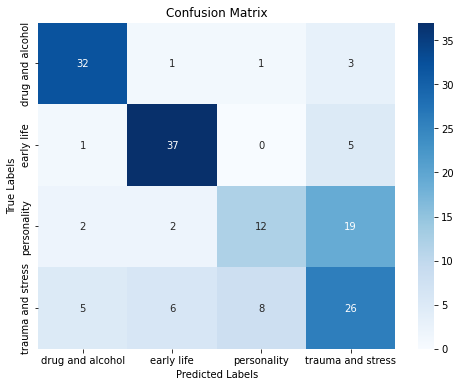

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Tokenize the validation data using the best max_length
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=best_params['max_length'])

# Convert to TensorFlow dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(best_params['batch_size'])

# Get predictions on the validation set
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)  

# True labels (validation set labels)
true_labels = val_labels

# Compute Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=label_map.keys())
print("\nClassification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
